# Overview

All scenario's notebooks have the same structure:

- [Description of the scenario](#description)
- [Analysis of the calibration step in the real world and obtain calibration values for SimGrid's execution](#calibration)
- [Analysis of the execution of the scenario and comparison with the predicted results obtained in SimGrid](#comparison)

<a id='description'></a>
# 2nd scenario results

This file describes the steps used to perform the experiment, and provides visualizations of the results.

## Scenario

The scenario consists in 2 computing node. The datasource will send requests to the first computing node.
Work amounts (loop iterations) are the same on both compute nodes and the experiment is launched several times with different amount of works. The first node once done processing the request sends it to the second node through rabbitmq, which will in turn send the result to the sink once finished as in scenario 1.

The experiment lasts for 5 minutes and is repeated 4 times for each work amount (40*4=160 launches) to limit random effects.

Here are the parameters used:

```
----------------------------------------------------
PARAMETERS:
suffix: reprodscen1
Parallelization degree: 10
HostLogPath: /home/clem/logs_expe/goLogs/reprod_scenario1_/
nbIters: start=1, end=80000001, iter=2000000
Samples: 4
Timestamp file: /go/src/app/timestamps/default5TimeStamps.csv
First core used: 0
----------------------------------------------------

```

## Reproduce

This scenario was launched on Grid'5000's paravance cluster.

Example of node reservation: `oarsub -p "cluster='paravance'" -l host=4,walltime=6 -I`

The experiment was launched using: `repoPath="/home/ccourageuxsudan/SGMicroservices/calvin-microbenchmarks/rabbitmqGo/" onG5K=1 run=1 scenario=1 bash launcherReproduce.s`

## Output

Output logs for this scenario can be found under:

- For the calibration step: `results_reprod/reprod_calib_2021-04-08_10-04-45/`
- For the execution: `results_reprod/reprod_scenario2_2021-04-08_10-04-45/`

# Initialization code

In [2]:
library(viridis)
library(ggplot2)
library(plotly)
library(plyr)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(zoo)
library(ggpointdensity)
library(hexbin)

getwd()
# modify default plots size
options(repr.plot.width=15, repr.plot.height=7)
#setwd("yourpathifnecessary")

[1] "/home/clem/Code/github.com/klementc/calvin-microbenchmarks/comparison"

# Load Datasets

In [20]:
##### CALIBRATION
data_calibration <- as_tibble(read.csv("results_reprod/reprod_calib_2021-04-08_10-04-45/1_aggrResults_1-10000000-100000002_4.csv"))

# preprocess to obtain timestamps as seconds instead of microseconds
data_calibration$timestampSec <- as.numeric(as.character(data_calibration$timestamp)) / 1e9
data_calibration$computeDurSec <- as.numeric(as.character(data_calibration$computeDur)) / 1e9
data_calibration$computeNode <- sub("\\_.*", "", data_calibration$serviceName)
summary(data_calibration)


data_calibration_sg <- as_tibble(read.csv("results_reprod/sg_calib/aggrResults_cal_scenario2.csv"))
summary(data_calibration_sg)

###### LOAD EXECUTION
data_SG_load <- as_tibble(read.csv("results_reprod/sg_run/sg_load_scenario2.csv"))
data_load_RW <- as_tibble(read.csv("results_reprod/reprod_scenario2_2021-04-08_10-04-45/2_aggrResults_1-2000000-80000001_4.csv"))
data_load_RW$timestampSec <- as.numeric(as.character(data_load_RW$timestamp)) / 1e9
data_load_RW$computeDurSec <- as.numeric(as.character(data_load_RW$computeDur)) / 1e9
data_load_RW$computeNode <- sub("\\_.*", "", data_load_RW$serviceName)
summary(data_load_RW)


 serviceName            nbIter        timestamp          totDurInServ     
 Length:4400        Min.   :1e+00   Min.   :0.000e+00   Min.   :    1568  
 Class :character   1st Qu.:2e+07   1st Qu.:7.425e+10   1st Qu.: 6933182  
 Mode  :character   Median :5e+07   Median :1.485e+11   Median :17119426  
                    Mean   :5e+07   Mean   :1.485e+11   Mean   :17209184  
                    3rd Qu.:8e+07   3rd Qu.:2.228e+11   3rd Qu.:26416244  
                    Max.   :1e+08   Max.   :2.970e+11   Max.   :45089580  
   computeDur          parExec       totReqProcessed   scenario        
 Min.   :     259   Min.   :0.0000   Min.   : 0.00   Length:4400       
 1st Qu.: 6930969   1st Qu.:0.0000   1st Qu.:24.75   Class :character  
 Median :17116579   Median :1.0000   Median :49.50   Mode  :character  
 Mean   :17206886   Mean   :0.5395   Mean   :49.50                     
 3rd Qu.:26414248   3rd Qu.:1.0000   3rd Qu.:74.25                     
 Max.   :45087721   Max.   :1.0000   Max.  

       ts              qArr        instArr       startEx        endEx       
 Min.   :  4.00   Min.   :  4   Min.   :  4   Min.   :  4   Min.   :  4.00  
 1st Qu.: 76.03   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76.03  
 Median :151.02   Median :151   Median :151   Median :151   Median :151.02  
 Mean   :151.02   Mean   :151   Mean   :151   Mean   :151   Mean   :151.02  
 3rd Qu.:226.01   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226.01  
 Max.   :298.03   Max.   :298   Max.   :298   Max.   :298   Max.   :298.03  
     flops         
 Min.   :  263700  
 1st Qu.: 7041700  
 Median :17208700  
 Mean   :17208700  
 3rd Qu.:27375700  
 Max.   :34153700  

 serviceName            nbIter          timestamp          totDurInServ      
 Length:1323920     Min.   :1.0e+00   Min.   :0.000e+00   Min.   :     1247  
 Class :character   1st Qu.:1.8e+07   1st Qu.:1.180e+11   1st Qu.:  6518227  
 Mode  :character   Median :3.7e+07   Median :1.679e+11   Median : 13252919  
                    Mean   :3.7e+07   Mean   :1.728e+11   Mean   : 25510954  
                    3rd Qu.:5.6e+07   3rd Qu.:2.600e+11   3rd Qu.: 23297496  
                    Max.   :7.4e+07   Max.   :3.008e+11   Max.   :356039914  
   computeDur           parExec       totReqProcessed   scenario        
 Min.   :      237   Min.   :-2.000   Min.   :   0    Length:1323920    
 1st Qu.:  6516028   1st Qu.: 0.000   1st Qu.:1088    Class :character  
 Median : 13250912   Median : 0.000   Median :2176    Mode  :character  
 Mean   : 25372936   Mean   : 1.458   Mean   :2176                      
 3rd Qu.: 23278794   3rd Qu.: 1.000   3rd Qu.:3265                      
 Max.   :3560384

<a id='calibration'></a>
# Calibration Step

We perform it with one compute node only since they would execute on different cores and would both give very similar output.

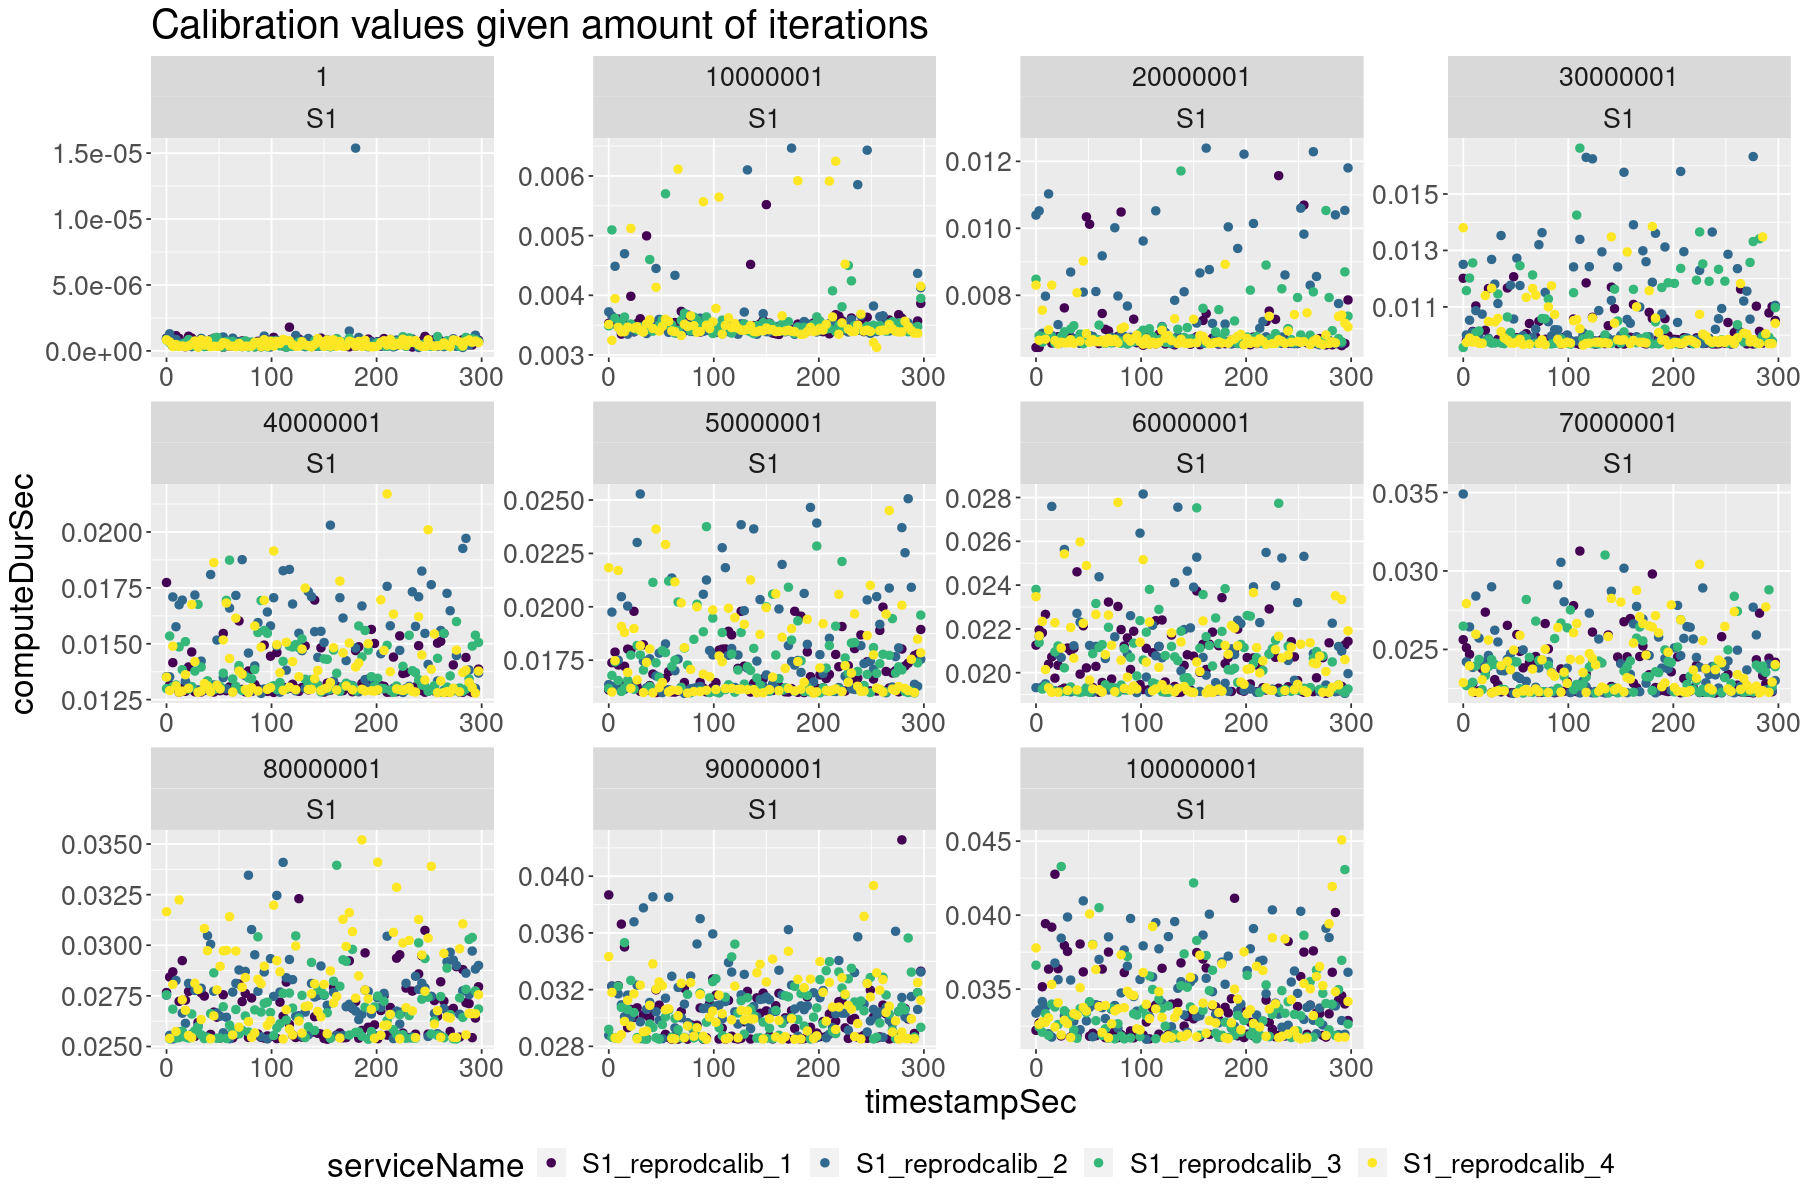

In [4]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data_calibration, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=2)+
    ggtitle("Calibration values given amount of iterations")+
    facet_wrap(nbIter ~ computeNode, scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) 

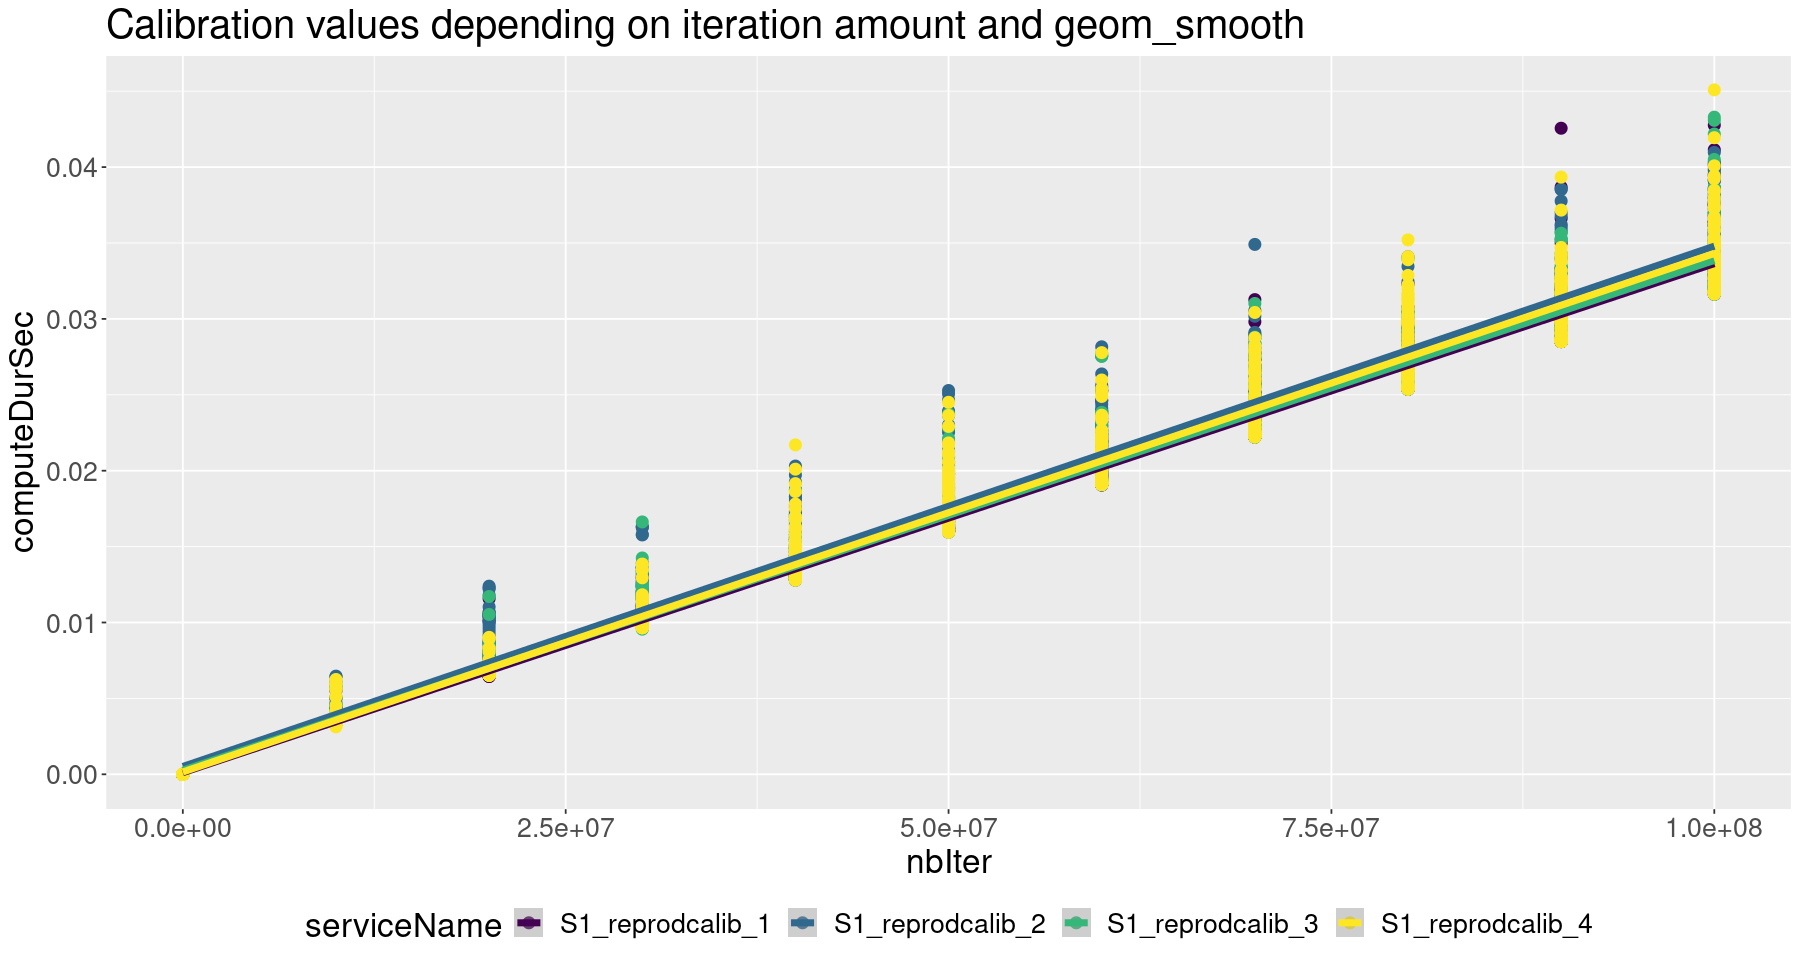

In [5]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data_calibration, aes(x=nbIter, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) + 
    ggtitle("Calibration values depending on iteration amount and geom_smooth")+
    geom_smooth(formula = y ~ x, method='lm', size=2)

## Linear regression to obtain calibration values

Given the previous graph, we can clearly observe (as expected) a linear relationship between the amount of work of the compute node, and the duration to execute a request. Thus we can use a linear regression to estimate the duration of a request given an amount of work (as a number of iterations). This value will then be used to calibrate our SimGrid code.

In [6]:
calibrationRegression = lm(computeDurSec ~ nbIter, data=data_calibration)
summary(calibrationRegression)


Call:
lm(formula = computeDurSec ~ nbIter, data = data_calibration)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0025377 -0.0009120 -0.0002634  0.0003361  0.0117983 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.637e-04  4.680e-05   5.635 1.86e-08 ***
nbIter      3.389e-10  7.911e-13 428.341  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001659 on 4398 degrees of freedom
Multiple R-squared:  0.9766,	Adjusted R-squared:  0.9766 
F-statistic: 1.835e+05 on 1 and 4398 DF,  p-value: < 2.2e-16


The obtained equation is:
### ```dur = nbIter*3.389*10**(-10)+2.637*10**(-4)``` 

## Utility function to obtain duration from nbIter

In [7]:
nbIter_to_duration <- function(nbIter) {
  return (nbIter*3.389*10**(-10)+2.637*10**(-4))
}

# utilitary function
nbIter_to_duration_to_SG <- function(start, end, iter, fact=1) {
    for(i in seq(from=start, to=end, by=iter)){
        cat(paste(trunc(fact*nbIter_to_duration(i)*10^9)," "))
    }
}

# example
print(nbIter_to_duration(2.5*10**8))
print(nbIter_to_duration(5*10**8))
print(nbIter_to_duration(7.5*10**8))

[1] 0.0849887
[1] 0.1697137
[1] 0.2544387


## Calibration comparison between real world data and SimGrid

In [8]:
start=1
end=100000002
iter=10000000

nbIter_to_duration_to_SG(start, end, iter)

263700  3652700  7041700  10430700  13819700  17208700  20597700  23986700  27375700  30764700  34153700  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > ~/logs_expe/sgLogs/calibration/aggrResults_cal_scenario2.csv
for i in 263700  3652700  7041700  10430700  13819700  17208700  20597700  23986700  27375700  30764700  34153700
do
    echo "Calibration for iterAmount=$i"
    parDeg=10 tsFile=../rabbitmqGo/timestamps/tsCal.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> ~/logs_expe/sgLogs/calibration/aggrResults_cal_scenario2.csv
done
```

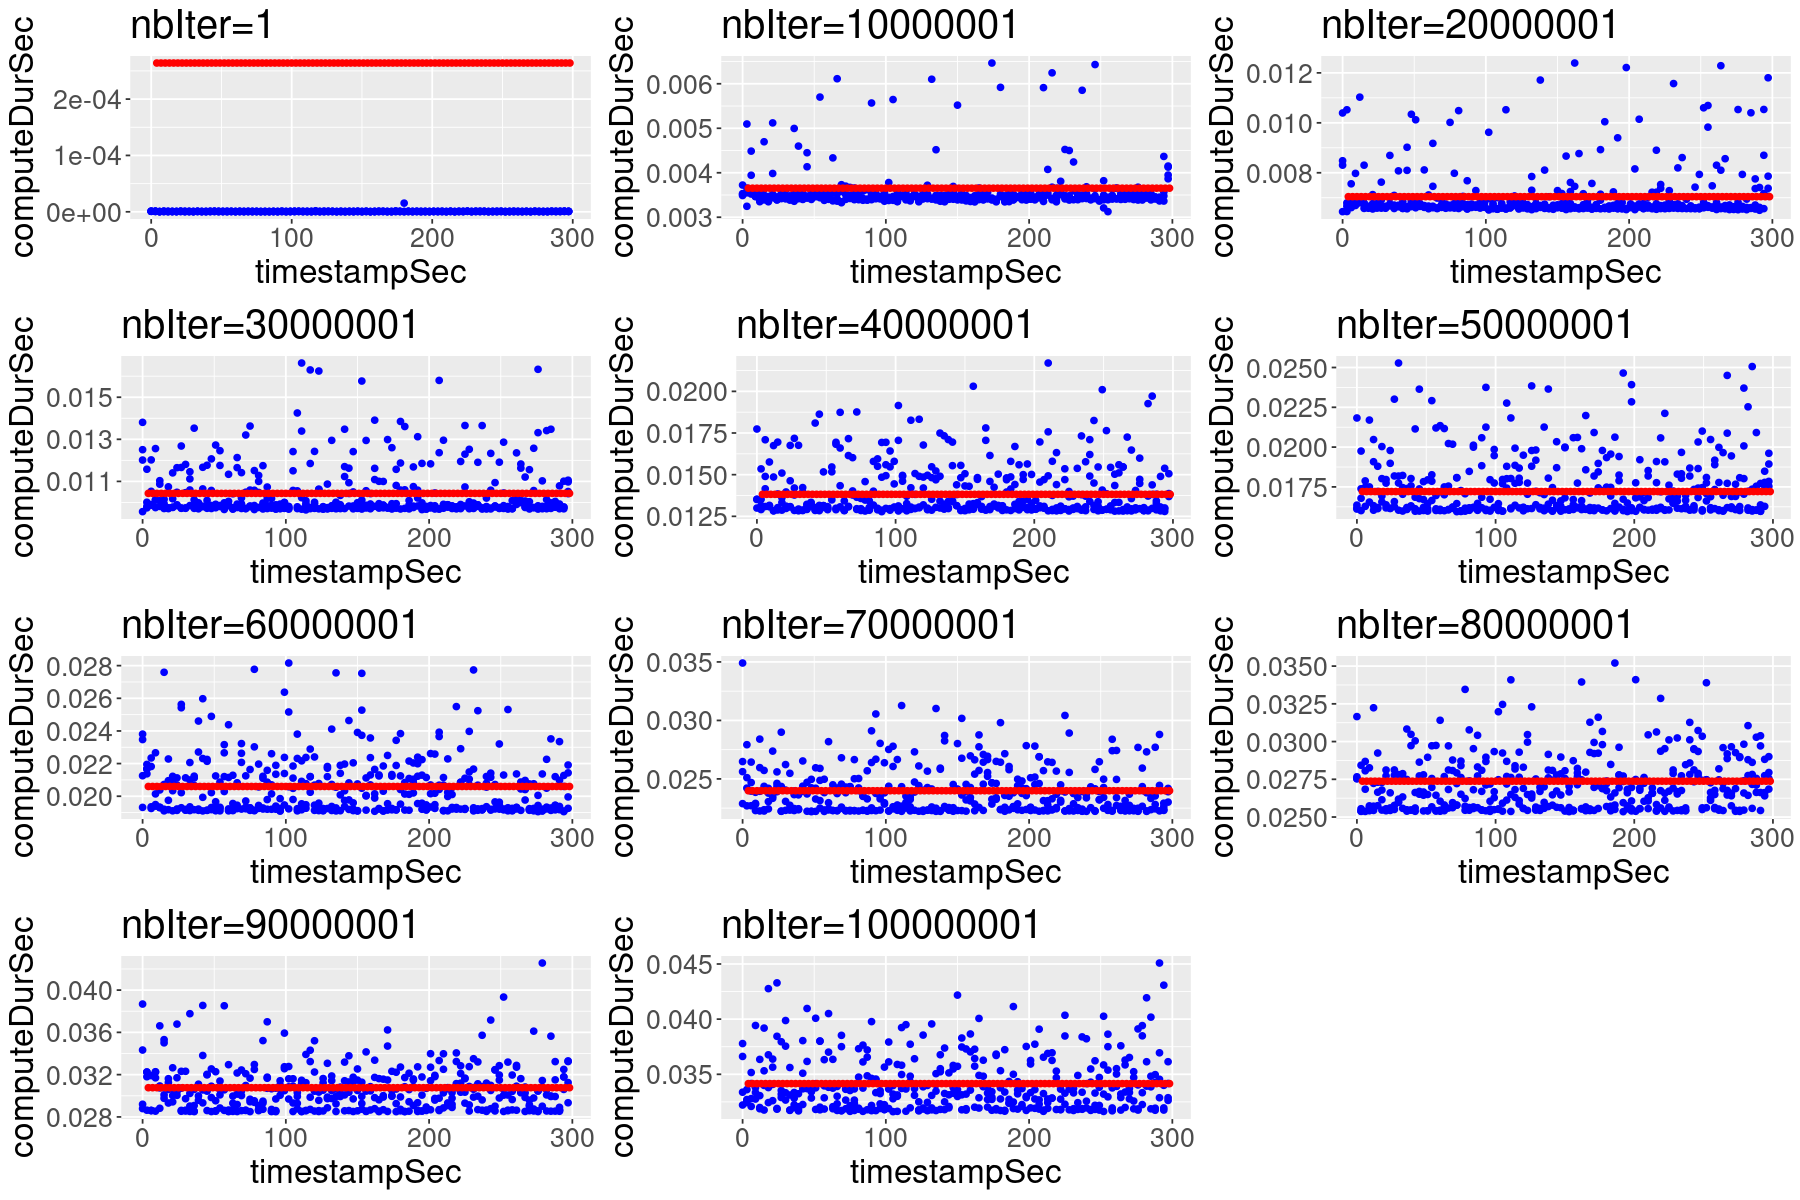

In [9]:
options(repr.plot.width=15, repr.plot.height=10)
P <- list()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red")+
        labs(title=sprintf("nbIter=%d",i))+
        theme(text = element_text(size = 20))+ 
        scale_color_viridis(discrete = TRUE, option = "D")+
        scale_fill_viridis(discrete = TRUE) 
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))

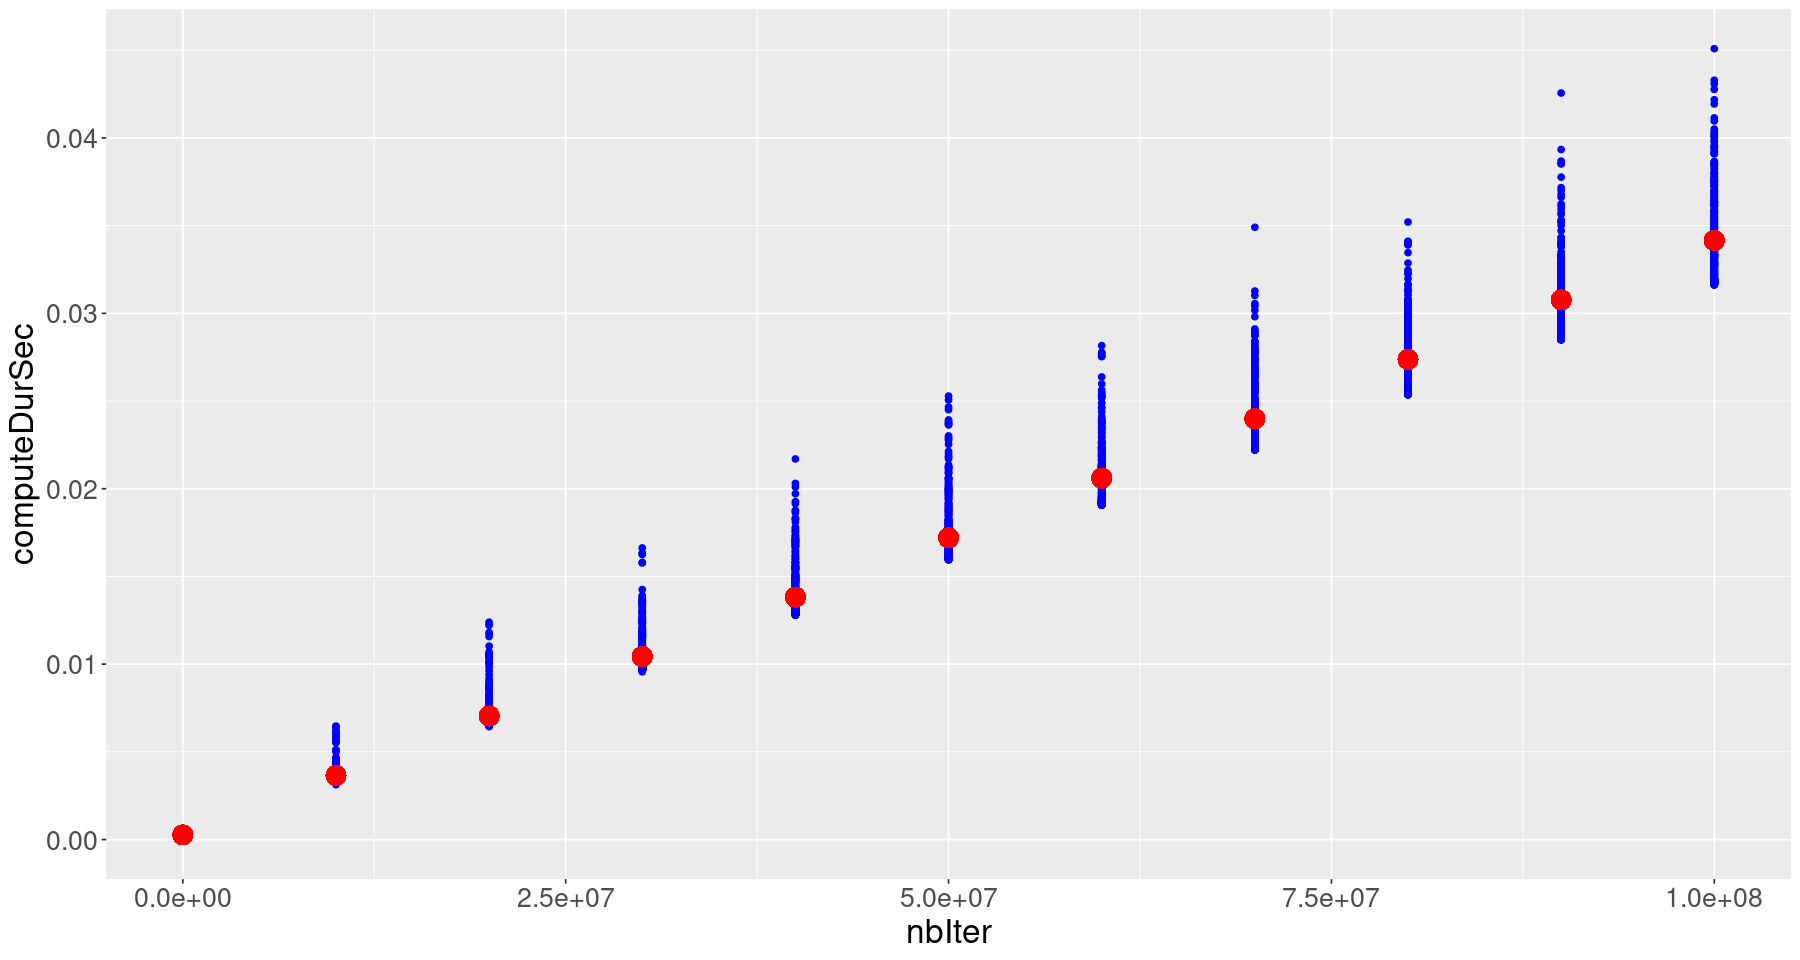

In [10]:

options(repr.plot.width=15, repr.plot.height=8)
P <- list()
g <- ggplot()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    tmpsg$nb <- i

    g <- g +
        geom_point(data = tmpG5K, aes(x=nbIter, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=nb, y=endEx-startEx), color = "red", size=5)+
        theme(text = element_text(size = 20))
    P <- c(P, list(g))
    
}
g

<a id='comparison'></a>
# Execution comparison


In [16]:
# obtain flop amount for 1GF nodes in SimGrid

start=1
end=80000001
iter=2000000

nbIter_to_duration_to_SG(start, end, iter)

263700  941500  1619300  2297100  2974900  3652700  4330500  5008300  5686100  6363900  7041700  7719500  8397300  9075100  9752900  10430700  11108500  11786300  12464100  13141900  13819700  14497500  15175300  15853100  16530900  17208700  17886500  18564300  19242100  19919900  20597700  21275500  21953300  22631100  23308900  23986700  24664500  25342300  26020100  26697900  27375700  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_load_scenario2.csv
for i in 263700  941500  1619300  2297100  2974900  3652700  4330500  5008300  5686100  6363900  7041700  7719500  8397300  9075100  9752900  10430700  11108500  11786300  12464100  13141900  13819700  14497500  15175300  15853100  16530900  17208700  17886500  18564300  19242100  19919900  20597700  21275500  21953300  22631100  23308900  23986700  24664500  25342300  26020100  26697900  27375700 
do
    echo "Calibration for iterAmount=$i"
    scenario=2 parDeg=10 tsFile=default5TimeStamps.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_load_scenario2.csv
done
```

# Time spent in first node

In [ ]:

options(repr.plot.width=15, repr.plot.height=50)

P <- list()
for(i in seq(from=1, to=80000001, by=2000000)){
    tmpsg <- subset(data_SG_load, serv=="service1" & flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, computeNode == "S1" & nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))


# Time spent in second node

In [ ]:

options(repr.plot.width=15, repr.plot.height=50)

P <- list()
for(i in seq(from=1, to=80000001, by=2000000)){
    tmpsg <- subset(data_SG_load, serv=="service2" & flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, computeNode == "S2" & nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))
